# Filtering procedure

Since the 15 second window is too long to get any valuable information, the data will be split into fixed length windows. 
This notebook is focused on cleaning up after splitting. When splitting some of the new windows might not contain any abnormalities, hence these will need to be remarked as 'normal'
This procedure introduces a new layer of uncertainty in the classification

In [222]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(1, module_path + '/src')

import utility

import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter


import librosa
from scipy.stats import skew 

from scipy.io.wavfile import write
import pygame

from tkinter import *
#import tkinter as tk
#from tkinter.ttk import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


figure_path = module_path + '/figures/'


target_rate = 44100
ds_target_rate = 8000

names = []
files_path = '/home/andrine/Desktop/TromsoDataset/Hasse413/'
names_full = os.listdir(files_path)
for n in names_full:
    if '_lungelyd_' in n:
        names.append(n)
del names_full
        
X = pd.read_stata('/home/andrine/Desktop/TromsoDataset/hasse_413_ut.dta')
X_no_nan = X.dropna(thresh=1, axis=1)
del X

cols = []

for col in X_no_nan:
    if np.any(X_no_nan[col] != ''):
        cols.append(col)
    else:
        continue
        
X_no_nan = X_no_nan[cols]
del cols

# Code to get info from annotation file

In [221]:
map_wav = {
    '1': 'a',
    '2': 'b',
    '3': 'c',
    '4': 'd',
    '5': 'e',
    '6': 'f'
}


def info_first_insp_exp(X, idx, label, wav):
    i = map_wav[wav]
    res = {
        0 : 'not evaluated',
        1 : 'yes',
        2 : 'no'
    }
    first_abnormalities = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_pres_1st_t72', f'sub_{i}_ob1_i_wh_pres_1st_t72'],
                'exp_wheeze': [f'sub_{i}_ob2_e_wh_pres_1st_t72', f'sub_{i}_ob1_e_wh_pres_1st_t72'],
                'insp_crackle': [f'sub_{i}_ob2_i_cr_pres_1st_t72', f'sub_{i}_ob1_i_cr_pres_1st_t72'] , 
                'exp_crackle' : [f'sub_{i}_ob2_e_cr_pres_1st_t72', f'sub_{i}_ob1_e_cr_pres_1st_t72']}
    f = X.iloc[idx][first_abnormalities[label]].values[0].astype(int)
    if  (f[0] < 0) or (f[1] < 0):
        print(X.iloc[idx][first_abnormalities[label]].values[0])
        return ''
    if f[0] == f[1]:
        return res[f[0]]
    return res[f[0]] + ' ' + res[f[1]]
    

def get_duration_or_timing(X, idx, label, wav):
    i = map_wav[wav]
    
    duration_res = {
        0 : 'not evaluated',
        1 : 'short',
        2 : 'ordinary', 
        3 : 'long'
    }
    timing_res = {
        0 : 'not evaluated',
        1 : 'early',
        2 : 'late',
        3 : 'early and late'
    }
    
    duration_timing_res = {'insp_wheeze' : duration_res,
                    'exp_wheeze': duration_res,
                    'insp_crackle': timing_res , 
                    'exp_crackle' : timing_res}
    
    
    duration_abnormalities = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_duration_t72', f'sub_{i}_ob1_i_wh_duration_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_duration_t72', f'sub_{i}_ob1_e_wh_duration_t72'],
                              
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_timing_t72', f'sub_{i}_ob1_i_cr_timing_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_timing_t72', f'sub_{i}_ob1_e_cr_timing_t72']}
    
    d = X.iloc[idx][duration_abnormalities[label]].values[0].astype(int)
    if  (d[0] < 0) or (d[1] < 0):
        print(X.iloc[idx][duration_abnormalities[label]].values[0])
        return ''
    elif (d[0] == d[1]):
        return duration_timing_res[label][d[0]] # Agreement 
    
    return duration_timing_res[label][d[0]] + ' ' + duration_timing_res[label][d[1]]

def get_second_round_eval(X, idx, label, wav):
    i = map_wav[wav]
    
    second_round_res = {
        0 : 'not evaluated',
        1 : 'present',
        2 : 'absent', 
        3 : 'uncertain'
    }

    second_round_pres =  {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_presence_t72', f'sub_{i}_ob1_i_wh_presence_t72'],
                    'exp_wheeze': [f'sub_{i}_ob2_e_wh_presence_t72', f'sub_{i}_ob1_e_wh_presence_t72'],
                    'insp_crackle': [f'sub_{i}_ob2_i_cr_presence_t72', f'sub_{i}_ob1_i_cr_presence_t72'] , 
                    'exp_crackle' : [f'sub_{i}_ob2_e_cr_presence_t72', f'sub_{i}_ob1_e_cr_presence_t72']}

    round2 = X.iloc[idx][second_round_pres[label]].values[0].astype(int)
    if  (round2[0] < 0) or (round2[1] < 0):
        print(X.iloc[idx][second_round_pres[label]].values[0])
        return ''
    elif (round2[0] == round2[1]):
        return second_round_res[round2[0]] # agreement
    
    
    return second_round_res[round2[0]] + ' ' + second_round_res[round2[1]]



def get_number_of_abnormalities(X, idx, label, wav):
    i = map_wav[wav]
    
    insp_exp = {
        'insp_wheeze' : 'inspiration',
        'exp_wheeze': 'expiration',
        'insp_crackle': 'inspiration', 
        'exp_crackle':  'expiration'
    }
    
    res = {
        0 : 'not evaluated',
        1 : f'1 {insp_exp[label]}',
        2 : f'2 {insp_exp[label]}s',
        3 : f'More than 3 {insp_exp[label]}s'
    }

    number_abnormalities = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_number_insp_t72', f'sub_{i}_ob1_i_wh_number_insp_t72'],
                'exp_wheeze': [f'sub_{i}_ob2_e_wh_number_exp_t72', f'sub_{i}_ob1_e_wh_number_exp_t72'],
                'insp_crackle': [f'sub_{i}_ob2_i_cr_number_insp_t72', f'sub_{i}_ob1_i_cr_number_insp_t72'] , 
                'exp_crackle' : [f'sub_{i}_ob2_e_cr_number_exp_t72', f'sub_{i}_ob1_e_cr_number_exp_t72']}
    n = X.iloc[idx][number_abnormalities[label]].values[0].astype(int)
    if n[0] == n[1]:
        if n[0]>= 0:
            return res[n[0]]
        else:
            print(n[0])
            return ''
    return res[n[0]] + ' ' + res[n[0]]
    
def get_comments(X , idx, label,  wav):
    i = map_wav[wav]
    cols_1 = [f'lung{i}_comment_c_t72', f'lung{i}_comment_b_t72', f'lung{i}_comment_a_t72'] 
    c_1 = X.iloc[idx][cols_1].values[0]
    
    cols_2 = {'insp_wheeze' : [f'sub_{i}_ob2_i_wh_unc_comment_t72', f'sub_{i}_ob1_i_wh_unc_comment_t72'],
                'exp_wheeze': [f'sub_{i}_ob2_e_wh_unc_comment_t72', f'sub_{i}_ob1_e_wh_unc_comment_t72'],
                'insp_crackle': [f'sub_{i}_ob2_i_cr_unc_comment_t72', f'sub_{i}_ob1_i_cr_unc_comment_t72'] , 
                'exp_crackle' : [f'sub_{i}_ob2_e_cr_unc_comment_t72', f'sub_{i}_ob1_e_cr_unc_comment_t72']}
    
    c_2 = X.iloc[idx][cols_2[label]].values[0]
    
    total_len = len(c_1[0]) + len(c_1[1]) + len(c_1[2]) + len(c_2[0]) + len(c_2[1])
    if total_len == 0:
        return ''
    c = np.append(c_1,c_2)
    return ' '.join(list(filter(len, c)))

def get_column_observer_wav_file(observer, wav): 
    i = map_wav[wav]


    classify_dict = {
        'a' : [f'lung{i}_abnormal_sound_a_t72',
        f'lung{i}_insp_wheeze_a_t72',
        f'lung{i}_exp_wheeze_a_t72',
        f'lung{i}_insp_crackle_a_t72',
        f'lung{i}_exp_crackle_a_t72',
        f'lung{i}_other_abnorm_sound_a_t72',
        f'lung{i}_not_classifiable_a_t72'],

        'b' :  [f'lung{i}_abnormal_sound_b_t72',
        f'lung{i}_insp_wheeze_b_t72',
        f'lung{i}_exp_wheeze_b_t72',
        f'lung{i}_insp_crackle_b_t72',
        f'lung{i}_exp_crackle_b_t72',
        f'lung{i}_other_abnorm_sound_b_t72',
        f'lung{i}_not_classifiable_b_t72'],


        'c' : [f'lung{i}_abnormal_sound_c_t72',
        f'lung{i}_insp_wheeze_c_t72',
        f'lung{i}_exp_wheeze_c_t72',
        f'lung{i}_insp_crackle_c_t72',
        f'lung{i}_exp_crackle_c_t72',
        f'lung{i}_other_abnorm_sound_c_t72',
        f'lung{i}_not_classifiable_c_t72']
    }
    
    return classify_dict[observer]

def get_label(X , idx, wav):
    annotation_list = ['abnormal_sound', 'insp_wheeze',
                   'exp_wheeze', 'insp_crackle', 'exp_crackle',
                  'other', 'not_classifiable']
    
    a_obs = X.iloc[idx][get_column_observer_wav_file('a', wav)].values[0]
    b_obs = X.iloc[idx][get_column_observer_wav_file('b', wav)].values[0]

    if np.any(a_obs != b_obs):
        c_obs = X.iloc[idx][get_column_observer_wav_file('c', wav)].values[0]
    else:
        c_obs = a_obs


    if (c_obs[0] == 0) or (np.isnan(c_obs[0])):
        label = 'normal'
    else:
        try:
            label_idx = np.where(c_obs == 1.)[0]
            label = annotation_list[label_idx[1]]
            if len(label_idx) > 2:
                print('more than one abnormality')
                return None
        except IndexError as error:
            return None
            
            
    return label

def get_sub_audios(audio, frac):
    base = len(audio)//frac
    half_base = base //2
    lengths = [(0, base)]

    while lengths[-1][1] < len(audio):
        start = lengths[-1][0] + base - half_base
        end = lengths[-1][1] + base - half_base
        lengths.append((start, end))
        #print(end - start)
        
    lengths[-1] = (lengths[-1][0] , len(audio))
    
    if (lengths[-1][1] - lengths[-2][1]) < 200: # If there only is 200 points not overlapping, this will be discarded
        return lengths[0:-1]
    
    next_to_last_len = lengths[-2][1] - lengths[-2][0]
    last_len = lengths[-1][1] - lengths[-1][0]
    
    
    if next_to_last_len != last_len: # Making sure that all windows are of same length
        diff = next_to_last_len - last_len
        lengths[-1] = (lengths[-1][0] - diff, lengths[-1][1])
    
    
    return lengths



## Code for getting a dataframe containing all abnormalities, slicing info and general info

In [4]:
frac = 4
data_to_filter = pd.DataFrame({
                    'filename' : [],
                    'patient_id' : [],
                    'start_idx' : [],
                    'end_idx': [],
                    'label' : [],
                    'nr_of_ab' : [],
                    'round2_presence' : [],
                    'duration_timing' : [],
                    'first' : [],
                    'comment': []
                })


for n in names:
    i = n[0:8]
    wav = n.split('.')[0][-1]
    row_idx = np.where(X_no_nan['unikt_lopenr'] == i)[0]
    label = get_label(X_no_nan , row_idx, wav)
    #print(label)
    if (label != None) and (label not in ['normal', 'other', 'not_classifiable']):
        number_of_ab = get_number_of_abnormalities(X_no_nan, row_idx, label, wav)
        
        comment = get_comments(X_no_nan , row_idx, label, wav)

        round2 = get_second_round_eval(X_no_nan, row_idx, label, wav)
        
        duration = get_duration_or_timing(X_no_nan, row_idx, label, wav)

        try:
            audio_file = files_path + n
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            continue

        try:
            audio = utility.denoise_audio(audio)

            audio, sr = utility.downsample(audio, sr, 8000), 8000

            lengths = get_sub_audios(audio, frac)

            for idx, l in enumerate(lengths):
                if idx == 0:
                    first = info_first_insp_exp(X_no_nan, row_idx, label, wav)
                else: 
                    first = ''

                new_data_to_filter = pd.DataFrame({
                    'filename' : [audio_file],
                    'patient_id' :  [i],
                    'start_idx' : [int(l[0])],
                    'end_idx': [int(l[1])],
                    'label' : [label],
                    'nr_of_ab' : [number_of_ab],
                    'round2_presence' : [round2],
                    'duration_timing' : [duration],
                    'first' : [first],
                    'comment': [comment]
                })

                data_to_filter = data_to_filter.append(new_data_to_filter)
        except ValueError as error:
            continue
            
            
del X_no_nan
del names     
data_to_filter = data_to_filter.reset_index(drop = True)

more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
-9223372036854775808
[nan nan]
[nan nan]
[nan nan]
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
-9223372036854775808
[nan nan]
[nan nan]
[nan nan]
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one 

/home/andrine/Desktop/AndrineElsetronning_Master2021/src/utility.py:212: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (rate, data) = wf.read(str_filename)
/home/andrine/Desktop/AndrineElsetronning_Master2021/src/utility.py:212: WavFileWarning: Incomplete chunk ID: b'\x00', ignoring it.
  (rate, data) = wf.read(str_filename)


more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
-9223372036854775808
[nan nan]
[nan nan]
[nan nan]
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one abnormality
more than one

### Saving a copy, to avoid doing computation over again

In [6]:
data_to_filter = pd.read_csv(module_path + '/data/data_to_filter.csv')

# Code for making procedure window

In [289]:
from tkinter.ttk import *

def play_soundfile_tkinter(root, audio, sr):
    write('test.wav', sr, audio)

    pygame.mixer.init()# initialise the pygame
    s = pygame.mixer.Sound("test.wav")
    s.play(loops=0)
    
    def play():
        s.play(loops=0)
        
    def stop():
        s.stop()
        
    play_button = tk.Button(root, text="play lung sound", command=play, height = 5, width = 20, bg = 'white')
    play_button.grid(row=2, column = 1 , pady = 10)
    
    stop_button = tk.Button(root, text="stop lung sound", command=stop, height = 1, width = 20)
    stop_button.grid(row=5 , column = 1, pady = 10)
    #root.mainloop()
    return root, s
    
    
def plot_lung_sound_tkinter(root, audio, sr):
    duration = float(len(audio)) / sr
    T = 1.0/sr
    N = int(duration / T)
    x = np.linspace(0.0, N*T, N)
    if len(x) != len(audio):
        x = np.linspace(0.0, N*T, N +1 ) 

    figure, ax = plt.subplots(1,1)
    figure.set_size_inches(15, 5)

    #root= tk.Tk() 
    chart_type = FigureCanvasTkAgg(figure, root)
    chart_type.get_tk_widget().grid(row = 6, columnspan=3)
    ax.plot(x, audio, linewidth = 0.3)

    ax.set_title('Lung sound plot')
    
    return root, figure


def make_window(audio, sr, info, label, odd_data_flag):
    label_map = {
        'insp_crackle': 'crackle',
        'insp_wheeze': 'wheeze',
        'exp_crackle': 'crackle',
        'exp_wheeze': 'wheeze'
    }
    
    
    label = [label_map[label]]
    odd_data_flag = [odd_data_flag]
    
    s = pygame.mixer.Sound("test.wav")

    nr_of_ab = info['nr_of_ab']
    round2 = info['round2']
    duration = info['duration']
    f = info['first']
    comment  = info['comment']
    
    short_info = f'\n {label} \n\n {nr_of_ab} \n\n {round2} \n\n {duration} '
    
    extended_info = f'\n LABEL: {label}  \n\n Number of abnormalities: {nr_of_ab}'
    extended_info = extended_info + f'\n\n Round 2 observer conclusion:  {round2}'
    extended_info = extended_info + f' \n\n Duration / timing : {duration}'

    if type(f) == float: 
        f = ''
    elif len(f) != 0:
        short_info = short_info + f'\n\n {f}'
        extended_info = extended_info + f'\n\n First breathing cycle presence: {f}'
    
    extended_info = extended_info + f'\n Comment : {comment}'
    
    def continue_loop():
        s.stop()
        root.destroy()
        
    '''
    def crackle():
        s.stop()
        global label
        label = 'crackle'
        continue_loop()
    
    def wheeze():
        s.stop()
        global label
        label = 'wheeze'
        continue_loop()
    '''
    def odd(odd_data_flag):
        odd_data_flag[0] = True
    
    def normal(label):
        s.stop()
        #global label
        label[0] = 'normal'
        continue_loop()
    
    root = Tk()
    root.title('Lung sound')
    root.geometry("1000x1000")
    
    title=Label(root,text="Play lung sound with following into") 
    title.config(font =("Courier", 13)) 
    title.grid(row = 0, columnspan=3)
    
    
    textbox = Text(root, height = 10, width = 52)
    textbox.config(font =("Courier", 12))
    textbox.grid(row = 1, columnspan=3)
    textbox.insert(END, short_info)
    
    root, s = play_soundfile_tkinter(root, audio, sr)
    
    #crackle_button = tk.Button(root, text="CRACKLE", command=crackle, bg = 'red', height = 2, width = 10) 
    #wheeze_button = tk.Button(root, text="WHEEZE",  command=wheeze, bg = 'blue', height = 2, width = 10)
    
    normal_button = tk.Button(root, text="NORMAL", command= lambda *args: normal(label), bg = 'green', height = 2, width = 10)
     
    #crackle_button.grid(row=4, column=0, pady = 10)
    #wheeze_button.grid(row=4, column=1, pady = 10)
    normal_button.grid(row = 4, column=1, pady = 10) 
    
    root, f = plot_lung_sound_tkinter(root, audio, sr)

    next_button = Button(root, text="Next", command=continue_loop)
    next_button.grid(row=3, columnspan=3, pady = 10)    
    
    
    textbox2 = Text(root, height = 14, width = 52)
    textbox2.config(font =("Courier", 9))
    textbox2.grid(row = 7, columnspan=3)
    textbox2.insert(END, extended_info)
    
    odd_button = tk.Button(root, text="ODD", command= lambda *args: odd(odd_data_flag), bg = 'red', height = 1, width = 10)
    odd_button.grid(row = 8, column=1, pady = 10) 
    
    
    root.mainloop()
    plt.close(f) # To close the figure if the root is shut down. Hence figure will not be plotted when program is done
    return label[0], odd_data_flag[0]

# Running filtering procedure

In [290]:
error_in_data = {}
count = 0

odd_data = pd.read_csv(module_path + '/data/odd_data.csv')
filtered_data = pd.read_csv(module_path + '/data/filtered_data.csv')
#filtered_data = data_to_filter.copy(deep = True)
for row in filtered_data.iterrows():
    idx = row[0]

    audio_file = row[1]['filename']
    start = int(row[1]['start_idx'])
    end = int(row[1]['end_idx'])
    label = row[1]['label']
    comment = row[1]['comment']
    odd_data_flag = False
    
    
    new_labels = ['crackle','wheeze','normal']
    if label in new_labels:
        continue
    
    nr_of_ab = row[1]['nr_of_ab']
    round2 = row[1]['round2_presence']
    duration = row[1]['duration_timing']
    f = row[1]['first']

    info = {
        'label' : label,
        'nr_of_ab': nr_of_ab,
        'round2': round2,
        'duration': duration,
        'first' : f,
        'comment': comment
    }
    
    try:
        sr, audio = utility.read_wav_file(audio_file, target_rate)

    except EOFError as error:
        error_in_data[audio_file] = 'EOFError'
        continue

    try:
        audio = utility.denoise_audio(audio)
        audio, sr = utility.downsample(audio, sr, 8000), 8000
        audio = audio[start : end]*10
        low_cut = 120
        high_cut = 2000
        
        #audio = butter_bandpass_filter(audio, low_cut, high_cut, sr, order=12)
        new_label, odd_data_flag = make_window(audio, sr, info, label, odd_data_flag)
        
        filtered_data.loc[idx, 'label'] = new_label
        
        if odd_data_flag:
            odd_data = odd_data.append(filtered_data.iloc[idx])
            odd_data.to_csv(module_path + '/data/odd_data.csv', index = False)
        
        filtered_data.to_csv(module_path + '/data/filtered_data.csv', index = False)
        count = count + 1
        
        if count == 100:
            break
    except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue

In [305]:
filtered_data = pd.read_csv(module_path + '/data/filtered_data.csv')
#filtered_data[filtered_data['label'] == 'normal']
filtered_data.shape

(12369, 10)

# Code to display a sample from odd data

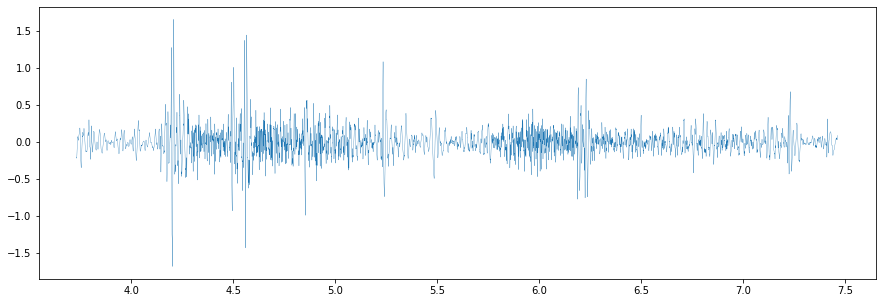

In [304]:
import IPython.display as ipd


test_idx = 0

odd_data = pd.read_csv(module_path + '/data/odd_data.csv')
audio_file = odd_data.loc[test_idx ,'filename' ]
start = int(odd_data.loc[test_idx ,'start_idx' ])
end = int(odd_data.loc[test_idx ,'end_idx' ])
label = odd_data.loc[test_idx ,'label' ]

audio_file = files_path + name

sr, audio = utility.read_wav_file(audio_file, target_rate)
audio = utility.denoise_audio(audio)
audio, sr = utility.downsample(audio, sr, 8000), 8000

duration = float(len(audio)) / sr
T = 1.0/sr
N = int(duration / T)
x = np.linspace(0.0, N*T, N)
if len(x) != len(audio):
    x = np.linspace(0.0, N*T, N +1 ) 

audio = audio[start : end]*10
x = x[start : end]
#plt.plot(x, audio)

figure, ax = plt.subplots(1,1)
figure.set_size_inches(15, 5)
ax.plot(x, audio, linewidth = 0.3)

ipd.Audio(audio, rate=sr) 